# XPS spectra identification and quantification

This project was published as a scientific resarch article with the title "Deep neural network for X-ray photoelectron spectroscopy data analysis" in the journal 'Machine Learning: Science and Technology'. A free version is available on the arXiv: https://arxiv.org/abs/1909.05529

The goal is to identify the elements present in a given epxerimentally meausred electron-emission (XPS) spectrum. With Dr. G. Drera we produced an artificial training sample made of fake spectra containing each 2-4 elements using advanced Monte Carlo simulations. A test set of real XPS spectra is also available. Challenges include contamination by oxygen and carbon, overall shift of the spectrum, and relative sensitivity of the peaks to the contamination levels.

## Python packages and basic function

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split #For splitting a set into training and test

# Keras items
import keras

In [2]:
# Save a trained model to a json and h5 file

def save_model(model, filename, path):
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(path + filename + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(path + filename + ".h5")
    
    print("Saved model to disk")

# Load a trained model saved with the save_model function    
    
def load_model(filename, path):
 
    # load json and create model
    json_file = open(path + filename + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path + filename + ".h5")
    
    return loaded_model

In [3]:
#Define the xps relative intensity for elements from z = 3 (lithium) to z = 83 (bismuth)
z_threshold = np.array([ 0.02690042,  0.07704826,  0.21056701,  0.37956232,  0.50214875,
    0.8389039 ,  1.2781961 ,  2.030549  ,  2.895051  ,  0.3938323 ,
    0.13641681,  0.13520968,  0.12879588,  0.20122653,  0.1839651 ,
    0.20770398,  0.28487498,  0.34013155,  0.6639688 ,  1.2232105 ,
    2.1499441 ,  3.4514627 ,  4.4178324 ,  5.5601149 ,  8.5126276 ,
    9.3818016 , 10.356577  ,  8.9705925 ,  0.7223503 ,  0.60683209,
    0.59862125,  0.46525857,  0.21884297,  0.21583223,  0.1527631 ,
    0.22720009,  0.44130668,  0.74013931,  1.1312765 ,  1.6618358 ,
    2.1005776 ,  2.4968209 ,  2.8142807 ,  2.9819212 ,  2.6759336 ,
    2.4045827 ,  2.1671715 ,  2.3641839 ,  2.4493639 ,  2.5727384 ,
    2.4075847 ,  1.5270671 ,  1.0054697 ,  2.0702636 ,  4.6083822 ,
    5.596025  ,  6.0214639 ,  6.7605233 ,  7.5784369 ,  2.5354369 ,
    0.51197964,  0.7296142 ,  0.72040737,  0.70293695,  0.91387457,
    0.83505982,  0.66152835,  0.41190755,  0.71862513,  0.66354334,
    1.0555228 ,  1.3060269 ,  1.6404228 ,  1.9798533 ,  2.2094698 ,
    2.2872632 ,  2.2970097 ,  1.6634289 ,  1.5163039 ,  1.6659216 ,
    1.5038371 ])

# Define the number of energy bins of the spectra and the input shape of the neuronal network
NEnergies = 2000
input_spectra = keras.layers.Input(shape = (NEnergies,))

## Data

In [4]:
'''
Function that loads the synthetic and experimental data to create the training, test and validation dataset.
(x: network input ; y: label)

    normalized_sum: if True the intensity labels are normalized to sum up to 1.

    returns: x_train, y_train, x_test, y_test, x_val, y_val, contamination_label


training dataset: 70% randomly sampled synthetic spectra with *intensity* labels

test dataset: remaining 30% randomly sampled synthetic spectra with *intensity* labels

validation dataset: all the experimental spectra with *intensity* labels

syn_contamination: level of carbon contamination for the synthetic data [0,1]
'''

def data(normalized_sum = True, test_split_size = 0.3):
        
    #Load the synthetic spectra with fixed noise from binary file
    syn_spectra_bin = np.fromfile("./XPS_Data_Sample/Synthetic/Spectra_syn.bin", dtype=np.float32).reshape((-1,2000))
    syn_spectra = pd.DataFrame(syn_spectra_bin)
    
    #Load the synthetic *intensity* labels from binary file
    syn_intensity_bin = np.fromfile("./XPS_Data_Sample/Synthetic/Intensity_syn.bin", dtype=np.float32).reshape((-1,81))
    syn_intensity = pd.DataFrame(syn_intensity_bin)
    if normalized_sum: syn_intensity = syn_intensity.div(syn_intensity.sum(axis=1), axis=0) #Normalize sum to one if normalized_sum = True
    
    #Load the contamination labels
    syn_contamination= np.fromfile("./XPS_Data_Sample/Synthetic/Contamination_syn.bin", dtype=np.float32)
    # Normalize to [0,1]
    syn_contamination = syn_contamination / syn_contamination.max()
    
    #Split the synthetic data into a training set and a test set with a default ratio 70/30
    x_train, x_test, y_train, y_test, y_train_conta, y_test_conta = train_test_split(syn_spectra.values, syn_intensity.values, syn_contamination, test_size = test_split_size)
    
    
    
    #Load the experimental spectra from csv
    exp_spectra = pd.read_csv("./XPS_Data_Sample/Experiment/Spectra_exp.dat", delimiter = '\t', header = None)
    #Load the experimental *true elemental quantification* labels from csv
    exp_elements = pd.read_csv("./XPS_Data_Sample/Experiment/Elements_exp.dat", delimiter = '\t', header = None)
    
    #Compute the normalized *intensity* for the experimental data
    intensity_labels = exp_elements * z_threshold 
    if normalized_sum: intensity_labels = intensity_labels.div(intensity_labels.sum(axis=1), axis=0)     #Normalize sum to one

    x_val = exp_spectra.values
    y_val = intensity_labels.values

    
    return x_train, y_train, x_test, y_test, x_val, y_val, y_train_conta

### Example of a spectra

In [17]:
#Load the data
x_train, y_train, x_test, y_test, x_val, y_val, y_train_conta = data(normalized_sum = True, test_split_size = 0.999)

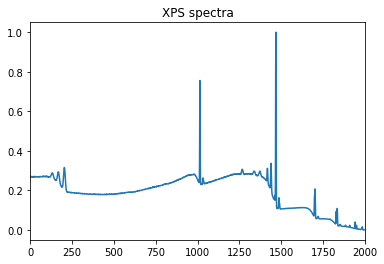

In [45]:
spectra = pd.DataFrame(x_train)
spectra.T[10].plot(title = 'XPS spectra')

## Network: inception and contamination subnets

### Custom layers and loss functions

In [5]:
# Normalization layer to have the network output sum to 1
# Using the Keras.backend

def norm_layer(y_pred):

    y_pred_sum = keras.backend.sum(y_pred, axis = 1, keepdims = True)
    y_pred_sum_tensor = keras.backend.repeat_elements(y_pred_sum, rep = 81, axis=1)
    y_pred_scaled = y_pred / y_pred_sum_tensor

    return y_pred_scaled

The custom loss function we use penalizes errors more when the true value is large. The loss for each single input spectra is given by

\begin{equation}
L_i(\overline{y}_i, y_i) = \sum_{k=1}^{81} \overline{y}_i^2 (y_i-\overline{y}_i)^2 
\end{equation}

and the overall loss is the average loss

\begin{equation}
L = \frac{1}{N}\sum_{i=1}^N L_i(\overline{y}_i, y_i) 
\end{equation}

In [6]:
# Low_pass loss function
def loss_low_pass_filter(y_true, y_pred):
    
    diff = keras.backend.square(y_true) * (keras.backend.square(y_pred - y_true))
    
    return keras.backend.mean(keras.backend.sum(diff, axis = 1))

### Inception - contamination network

In [7]:
def inception_contamination_net(input_shape, toprint = False):
    
    
    '''
    Denoising inception module
    
    Input: XPS spectra with 2000 bins
    
    Output: Denoised spectra with 2000 bins
    
    '''
    
    # Kernel sizes and filter size
    kernel_small = 1
    kernel_medium = 3
    kernel_large = 5
    Nfilters = 1

    # Add a dimension the input to obtain a tensor 2000 x 1 for the convolution
    reshape = keras.layers.Reshape((2000, 1))(input_shape)
    
    # 3 parallel 1D convolutions applied to the input (reshape)
    tower_1 = keras.layers.Conv1D(filters = Nfilters , kernel_size = kernel_small, padding='same', activation='relu')(reshape)
    tower_2 = keras.layers.Conv1D(filters = Nfilters , kernel_size = kernel_medium, padding='same', activation='relu')(reshape)
    tower_3 = keras.layers.Conv1D(filters = Nfilters , kernel_size = kernel_large, padding='same', activation='relu')(reshape)

    # Merge the ouput of the convolutions along the second axis to obtain a 2000 x 3 tensor
    merged = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=2)
    
    # 1D convolution(5 filtes kernel_size 4), average pooling (pool_size = 4, stride lenght = 4)
    conv_mixing = keras.layers.Conv1D(filters = 4, kernel_size = 5, activation='relu',padding='same')(merged)
    pooling = keras.layers.AveragePooling1D(pool_size = 4, strides = 4, padding= 'same')(conv_mixing)
    
    # Flatten the kernel to obtain a flat 2000 tensor
    inception_out = keras.layers.Flatten()(pooling)

    
    
    
    '''
    Contamination identification module
    
    Input: denoised spectra output of the inception module.
    
    Output: the contamination label
    
    '''
    
    drop_c = keras.layers.Dropout(rate = 0.20)(inception_out)
    linear_c = keras.layers.Dense(100, activation='sigmoid')(drop_c)
    conta_out = keras.layers.Dense(1, activation='sigmoid')(linear_c)
    
    
    
    
    '''
    Intensity identification module
    
    Input: denoised spectra output of the inception module and contamination label 
    from contamination identification module
    
    Output: 81 intensity labels normalized to sum 1
    

    '''
    
    # Attach the output of the contamination layer to the ouput of the inception layer
    merged_incep_conta = keras.layers.concatenate([conta_out, inception_out], axis=1)
    
    # Dropout and intensity identification (81 values)
    drop_1 = keras.layers.Dropout(0.2)(merged_incep_conta)
    linear_1 = keras.layers.Dense(2000, activation = 'relu')(drop_1)
    linear_2 = keras.layers.Dense(81, activation='sigmoid')(linear_1)
    
    # Normalize the sum of the intensities to 1 with the custom norm_layer
    norm_intensity_out = keras.layers.core.Lambda(norm_layer, output_shape = (81,) )(linear_2)

    '''
    Define the keras model with the inception denoising module, the contamination module and
    the intensity quantification module
    '''
    
    model = keras.models.Model(input_shape, [conta_out, norm_intensity_out])
    
    # Print the summary of the model if toprint = True
    if toprint: print(model.summary())
    
    return model

In [8]:
# Prints out the summary of the model
my_model = inception_contamination_net(input_spectra, toprint = True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2000, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2000, 1)      2           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2000, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (

## Example how to train

Note: For demonstration purposes we will set the size of the training set to be very small such that the training can easily be done on Laptop. The so obtained trained network has then extremely poor classification performance obviously. If you want to use it, please change test_split_size to a reasonable ratio (e.g. 0.3).

In [41]:
#Load the data
x_train, y_train, x_test, y_test, x_val, y_val, y_train_conta = data(normalized_sum = True, test_split_size = 0.999)

# The real value of the contamination for the experimental data is not known. Thus, we use an array of 0 
# for the validation value of the contamination
foo_y_val_conta = np.array([np.zeros(534)]).transpose()

In [42]:
params = {
    'batch_size': 32,
    'epochs': 100,
    'optimizer': 'adam',
    'loss': ["mse", loss_low_pass_filter]
}

my_model.compile(optimizer = params['optimizer'], loss = params['loss'], metrics=['accuracy'])

In [43]:
results = my_model.fit(x_train, [y_train_conta, y_train], batch_size=params['batch_size'], epochs= params['epochs'], verbose = 1, validation_data=(x_val, [foo_y_val_conta, y_val]))

Train on 117 samples, validate on 534 samples
Epoch 1/100
117/117 [==============================] - 3s 29ms/step - loss: 0.1237 - dense_2_loss: 0.0220 - lambda_1_loss: 0.1017 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.5641 - val_loss: 0.4328 - val_dense_2_loss: 0.2230 - val_lambda_1_loss: 0.2098 - val_dense_2_acc: 0.6498 - val_lambda_1_acc: 0.2397
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.1082 - dense_2_loss: 0.0210 - lambda_1_loss: 0.0872 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.5556 - val_loss: 0.3800 - val_dense_2_loss: 0.1676 - val_lambda_1_loss: 0.2124 - val_dense_2_acc: 0.7491 - val_lambda_1_acc: 0.2247
Epoch 3/100
117/117 [==============================] - 1s 8ms/step - loss: 0.1014 - dense_2_loss: 0.0204 - lambda_1_loss: 0.0810 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.6154 - val_loss: 0.4032 - val_dense_2_loss: 0.1920 - val_lambda_1_loss: 0.2111 - val_dense_2_acc: 0.6891 - val_lambda_1_acc: 0.2566
Epoch 4/100
117/117 [=================

Epoch 28/100
117/117 [==============================] - 1s 5ms/step - loss: 0.0383 - dense_2_loss: 0.0106 - lambda_1_loss: 0.0277 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.7863 - val_loss: 0.3742 - val_dense_2_loss: 0.2058 - val_lambda_1_loss: 0.1684 - val_dense_2_acc: 0.6723 - val_lambda_1_acc: 0.3801
Epoch 29/100
117/117 [==============================] - 1s 5ms/step - loss: 0.0373 - dense_2_loss: 0.0117 - lambda_1_loss: 0.0257 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8120 - val_loss: 0.3744 - val_dense_2_loss: 0.2028 - val_lambda_1_loss: 0.1716 - val_dense_2_acc: 0.6685 - val_lambda_1_acc: 0.3708
Epoch 30/100
117/117 [==============================] - 1s 5ms/step - loss: 0.0370 - dense_2_loss: 0.0120 - lambda_1_loss: 0.0249 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8376 - val_loss: 0.3841 - val_dense_2_loss: 0.2117 - val_lambda_1_loss: 0.1723 - val_dense_2_acc: 0.6629 - val_lambda_1_acc: 0.3708
Epoch 31/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0371

Epoch 55/100
117/117 [==============================] - 1s 7ms/step - loss: 0.0280 - dense_2_loss: 0.0086 - lambda_1_loss: 0.0194 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8376 - val_loss: 0.3602 - val_dense_2_loss: 0.2090 - val_lambda_1_loss: 0.1512 - val_dense_2_acc: 0.6704 - val_lambda_1_acc: 0.3970
Epoch 56/100
117/117 [==============================] - 1s 7ms/step - loss: 0.0283 - dense_2_loss: 0.0095 - lambda_1_loss: 0.0188 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8632 - val_loss: 0.3436 - val_dense_2_loss: 0.1989 - val_lambda_1_loss: 0.1447 - val_dense_2_acc: 0.6760 - val_lambda_1_acc: 0.4345
Epoch 57/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0286 - dense_2_loss: 0.0100 - lambda_1_loss: 0.0186 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8291 - val_loss: 0.3632 - val_dense_2_loss: 0.2235 - val_lambda_1_loss: 0.1397 - val_dense_2_acc: 0.6348 - val_lambda_1_acc: 0.4532
Epoch 58/100
117/117 [==============================] - 1s 7ms/step - loss: 0.0276

Epoch 82/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0214 - dense_2_loss: 0.0069 - lambda_1_loss: 0.0145 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8803 - val_loss: 0.3598 - val_dense_2_loss: 0.2074 - val_lambda_1_loss: 0.1524 - val_dense_2_acc: 0.6573 - val_lambda_1_acc: 0.4345
Epoch 83/100
117/117 [==============================] - 1s 5ms/step - loss: 0.0240 - dense_2_loss: 0.0093 - lambda_1_loss: 0.0147 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8632 - val_loss: 0.3549 - val_dense_2_loss: 0.2023 - val_lambda_1_loss: 0.1526 - val_dense_2_acc: 0.6648 - val_lambda_1_acc: 0.4363
Epoch 84/100
117/117 [==============================] - 1s 5ms/step - loss: 0.0253 - dense_2_loss: 0.0105 - lambda_1_loss: 0.0149 - dense_2_acc: 0.0000e+00 - lambda_1_acc: 0.8462 - val_loss: 0.3535 - val_dense_2_loss: 0.2033 - val_lambda_1_loss: 0.1501 - val_dense_2_acc: 0.6648 - val_lambda_1_acc: 0.4326
Epoch 85/100
117/117 [==============================] - 1s 7ms/step - loss: 0.0202

If test_train_spli = 0.999, the training set is very small and thus the validation loss remains very large.

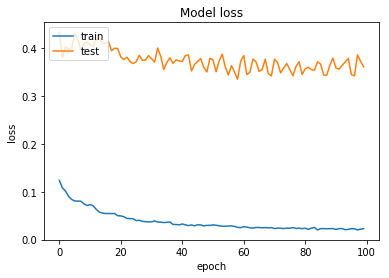

In [52]:
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()